# Stéréovision

![Suzanne](main.png)

La stéréovision est une discipline qui s’occupe de reconstruire des informations 3D à partir d’images. Ppour que la reconstruction d’un point soit possible, il faut plusieurs images de ce point. Ces images doivent être prises de points de vue différents. L’étape clé de la reconstruction, qui pose souvent problème, est d’indentifier l’image du point à reconstruire dans chacune des vues.

## Géométrie épipolaire

La géométrie épipolaire fait intervenir deux caméras. La géométrie épipolaire décrit les propriétés géométriques entre deux vues d’une même scène et ne dépend que des paramètres intrinsèques des caméras et de leurs positions relatives. Elle fournit, en particulier, la contrainte épipolaire, qui nous sera très utile pour produire les appariements entre vues.

## La matrice fondamentale

![Géométrie épipolaire - Sanyam Kapoor](https://i.imgur.com/GbafZIY.png)

Imaginons que nous ayons deux images, droite et gauche, de l’espace monde. Prenons un point $\vec{x}$ dans l’espace image droit. Le point $\vec{X}$ de l’espace monde, dont $\vec{x}$ est l’image, peut se trouver n’importe où sur la droite passant par $\vec{x}$ et le centre optique de la caméra de droite. Nous appellerons cette droite, le rayon retro-projeté de $\vec{x}$. Notons $\vec{x}'$ l’image de $\vec{X}$ dans l’espace image gauche. Le lieu de $\vec{x}'$ est donc la droite image du rayon retro-projeté de $\vec{x}$. Cette droite est appelée ligne épipolaire et notée $\vec{l}'$. La ligne épipolaire passe par l’épipole $\vec{e}'$, image du centre optique de la caméra de droite.

En géométrie projective 2D, une droite d’équation $ax+by+c = 0$ est représentée par un vecteur à trois composantes $(a, b, c)^T$ définies à un facteur près. On a donc la relation suivante:

>Le point $\vec{x}$ appartient à la droite $\vec{l}$ si et seulement si $x^T\vec{l} = 0$.

De plus, en géométrie projective 2D, les relations remarquables suivantes sont valables:

- L’intersection de deux lignes $l$ et $l'$ est donnée par $x = l \times l'$,
- La droite passant par deux points $x$ et $x'$ est donnée par $l = x \times x'$.

Notons que le produit vectoriel peut être écrit comme un produit de matrice $x \times y = [x]_\times y$ où

$$[x]_\times = \begin{pmatrix} 0 & −x3 & x2 \\ x3 & 0 & −x1 \\ −x2 & x1 & 0 \end{pmatrix}$$

Pour trouver l’équation de la ligne épipolaire dans l’espace image gauche, il nous suffit donc de trouver les coordonnées de deux points de cette ligne. Le premier est l’image $P'\vec{C}$ du centre optique $\vec{C}$ de la caméra de droite où $P'$ est la matrice de projection de la caméra de gauche. Le deuxième est $P'P^{+}\vec{x}$ où $P^{+}$ est la pseudo inverse de la matrice de projection $P$ de la caméra de droite. La ligne épipolaire a donc pour équation $l' = [P'\vec{C}]_\times{}P'P^{+}\vec{x} = F\vec{x}$ avec $F = [P'\vec{C}]_\times{}P'P^{+}$. $F$ est appelée matrice fondamentale.

Comme la ligne épipolaire $\vec{l}' = F\vec{x}$ est le lieu de $\vec{x}'$, $\vec{x}'$ appartient donc à $\vec{l}'$ ce qui conduit à la contrainte épipolaire :

>**La matrice fondamentale est telle que pour toute paire de points se correspondant $\vec{x} \leftrightarrow \vec{x}'$ dans les deux images, on a $\vec{x}'^{T}F\vec{x} = 0$.**

## Calcul de la matrice fondamentale

La matrice fondamentale $F$ a sept degrés de liberté. Elle possède neuf composantes mais celles-ci sont définies à un facteur d’échelle près, ce qui enlève un degré de liberté. De plus, la matrice $F$ est une matrice singulière ($det(F) = 0$) ce qui nous fait bien sept degrés de liberté. Il nous faut donc sept correspondances minimum pour calculer $F$. L’équation $x'^{T}_iFx_i = 0$ et les sept correspondances nous permettent d’écrire un système d’équations de la forme $Af = 0$, où $f$ est le vecteur qui contient les composantes de la matrice $F$. Admettons que $A$ soit une matrice 7×9 de rang 7. La solution générale de $Af = 0$ peut s’écrire $\alpha f_1 + (1−\alpha) f_2$ où $f_1$ et $f_2$ sont deux solutions particulières indépendantes de $Af = 0$. On utilise ensuite la contrainte de singularité $det(\alpha F_1 + (1 − \alpha)F_2) = 0$ pour déterminer $\alpha$. La contrainte de singularité donnant lieu à une équation du troisième degré, on pourra avoir une ou trois solutions pour $F$.

## OpenCV

En pratique vous allez utiliser la bibliothèque OpenCV. En python, vous avez accès à ses fonctions grâce au module `cv2`.

Vous pouvez trouver de l'aide concernant les fonctions de calibration et de reconstruction à la page https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html

## Objectif

Dans le zip de l'énoncé vous trouverez deux séquences d'images prise par deux caméras pendant le balayage d'un objet par un plan laser.

![Laser](scanRight/scan0010.png)

Vous trouverez également des prises de vue d'un damier dans différentes position qui vous aideront à calibrer vos caméras.

![Damier](checkboards/c2Right.png)

Le but est de reconstruire en 3D l'objet scanné.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2 as cv
import glob

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)        # Tjrs rien compris au critère
objp = np.zeros((7*7,3), np.float32)                                            # On cree une liste de 0 contenant le nombre de d'intersections
objp[:,:2] = np.mgrid[0:7,0:7].T.reshape(-1,2)                                  # On modifie cette liste pour qu'elle aille de [0,0,0] a [NbInter,NbInter,0]

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

for fname in glob.glob('chessboards/c4*.png'):                                      #On le fait pour l'image 4 de gauche et droite donc *
    img = cv.imread(fname)                                                          #on choppe l'image et on la stocke dans une variable
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)                                       #on change la couleur de l'image a gris, pour trouver les coins plus facilement
    ret, corners = cv.findChessboardCorners(gray, (7,7),None)                       #on profite de cv pour trouver les coord des coins sur l'image, et ret = bool
    if ret: 
        objpoints.append(objp)                                                          #on ajoute a la liste 3D vide les coord qu'on a fixé des coins, donc (le premier coin étant le 0,0,0)
        imgpoints.append(corners)                                                       #on ajoute a la liste 2D vide les coord des coins
    

#Une fois que nous avons une liste des points 2d et une liste des points 3D correspondants, les matrices sont obtenables : 
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
# ret est un flag qui dit si ça a fonctionne ou pas
# mtx est la matrice intrinsèque de la caméra
# dist est la matrice de distorsion (inutile chez nous)
# rvecs et tvecs les vecteurs de translation et rotation

#matrice rotation, on utilise Rodrigues pour obtenir la matrice de rotation (3x3) à partir du vecteur de rotation (3x1)
rmatRight = cv.Rodrigues(rvecs[0])[0]
rmatLeft = cv.Rodrigues(rvecs[1])[0]

#matrice translation -> On colle le vecteur translation a la matrice  de rotation, elle passe de 3x3 a une 3x4 (LxC)
rotMatRight = np.concatenate((rmatRight,tvecs[0]), axis=1)
rotMatLeft = np.concatenate((rmatLeft,tvecs[1]), axis=1)

#matrice camera (cf Cours 1) -> MatriceIntrinsèque . MatriceRota (3x4 )
camLeft = mtx @ rotMatLeft
camRight = mtx @ rotMatRight

# matrice centre de projection -> (4x1 homogene) coordonnées de la camera
camWorldCenterLeft = np.linalg.inv(np.concatenate((rotMatLeft,[[0,0,0,1]]), axis=0)) @ np.transpose([[0,0,0,1]])
camWorldCenterRight = np.linalg.inv(np.concatenate((rotMatRight,[[0,0,0,1]]), axis=0)) @ np.transpose([[0,0,0,1]])


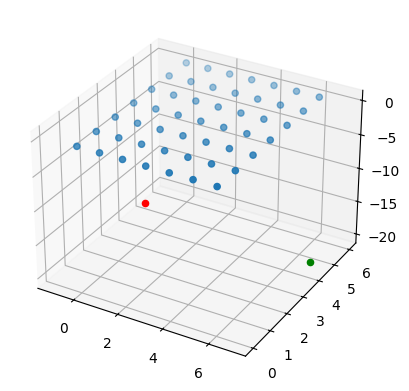

In [2]:
#Permet de visualiser dans l'espace la position de nos cameras et de l'objet (ici le jeu d'echecs)
def plotDotWorld():
    fig = plt.figure()                                      # cree une Figure vide
    ax = plt.axes(projection='3d')                          # on cree la figure avec des axes 3D (sans le projection c'est une fig 2D)
    
    ax.scatter3D(objp[:,0],objp[:,1],objp[:,2])             # On pose les points 3D de notre objet
    
    x,y,z,d = camWorldCenterLeft                            # les coord homogenes de notre camera gauche
    ax.scatter(x, y, z, c='g', marker='o')                  # on l affiche avec un une boule verte
    
    x2,y2,z2,d2 = camWorldCenterRight                       # les coord homogenes de notre camera droite
    ax.scatter(x2, y2, z2 , c='r', marker='o')              # on l affiche avec un une boule rouge
    
    plt.show()                                              #on l'affiche
    
plotDotWorld()          #On appelle la fonction

mask


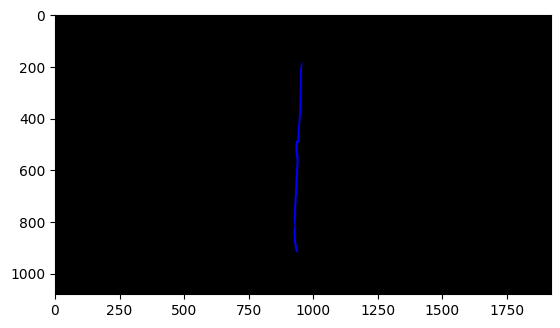

In [3]:
#sert juste a afficher le résultat de getImgLine(fname) une fois    
img = cv.imread("scanRight/scan0012.png")                                      #stocke l'image dans une variable
ret, mask = cv.threshold(img,127,255,cv.THRESH_TOZERO)                         #on enlève tout ce qui n'est pas la ligne
print("mask")
plt.imshow(mask)   

In [4]:
def crossMat(v):
    # Soit                          V = [[xxx][yyyy][zzzz]]
    v = v[:,0]    # qui donne donc  V = [xxx yyyy zzzz]               
            # Et on  retourne   ([[0000  -zzzz    yyyy]
            #                   [zzzz   0000   -xxxx]
            #                   [-yyyy  xxxx    0000]])

    return np.array([[0,-v[2],v[1]] , [v[2],0,-v[0]] , [-v[1],v[0],0]])


def matFondamental(camLeft,centerRight,camRight):
        # pseudo inverse de la matrice camRight, qu'on multiplie par camLeft (= MatriceIntrinsèque @ MatriceRota)
        # qu'on multiplie ensuite par (camLeft @centerRight) qui représente ...
        # Et on fait finalement le cross product (produit vectoriel) de la matrice colonne resultat
        return np.array(crossMat(camLeft @ centerRight) @ camLeft @ np.linalg.pinv(camRight))


def getImgLine(fname):              
    img = cv.imread(fname)                                      #stocke l'image dans une variable
    red = img[:,:,2]                                            #concrètement ça évite une erreur dans epiLine mais pq ?
    ret, mask = cv.threshold(red,127,255,cv.THRESH_TOZERO)      #vire tout ce qui n'est pas la ligne rouge
    return mask
    

def findEpilines(path):
    epilines = []
    for l in range(26):                                 #On a 25 images, donc pour chaque image
        if l<10:
            strp = path + '000' + str(l) +'.png'
        else:
            strp = path + '00' + str(l) +'.png'
            
        ImgLine = getImgLine(strp)                      #On transforme l'image en un fond avec simplement la ligne de gardée
        pointsLeft = [[],[],[]]

        for index, line in enumerate(ImgLine):              # on prends l'index de la ligne et la ligne correspondante
            for pixel in line:                              # pour chaque pixel de la ligne
                if pixel != 0:                              # si le pixel n'est pas nul (vu qu'on a viré tout le reste précédemment)
                    pixel = 1                               # sa valeur vaut 1
            try:
                pointsLeft[0].append(np.average(range(1920), weights = line))   # avg = sum(a * weights) / sum(weights)
                pointsLeft[1].append(index)                                     # index de la ligne
                pointsLeft[2].append(1)                                         # coord homogènes
            except:
                pass
            
        epilinesRight = Fondamental @ pointsLeft            # Comment il peut avoir Fondamental alors qu'il est défini hors de la fonction ?
        epilines.append([pointsLeft, epilinesRight])        # on stock pour cette image les pointsLeft et les epilinesRight
    return epilines


Fondamental = matFondamental(camRight,camWorldCenterLeft,camLeft)
# epl = [ [ [Red_x_avg], [Y_avg], [1] ], [EpilineRight(i)] ] ]
epl = findEpilines('scanLeft/')

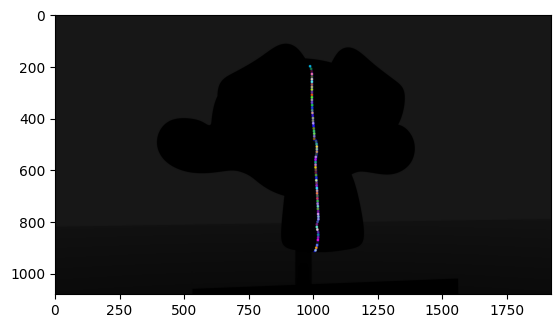

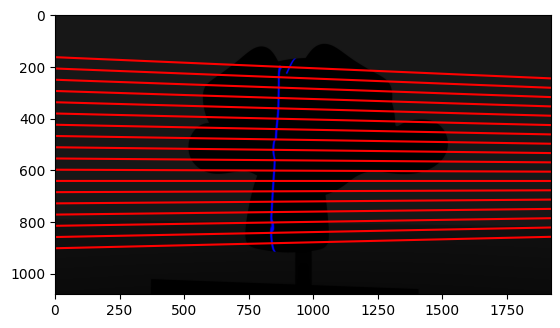

In [5]:
def drawAvgPoint(fname,EplLeft):                                                    # Cette fonction affiche les points de la ligne laser, input le nom de l'img et les pointsLeft de l'img
    img = cv.imread(fname)                                                          # 
    i = 0
    while i< len(EplLeft[0]):                                                       # Tant qu'il y a des "avg" qui n'ont pas été couverts
        color = tuple(np.random.randint(0,255,3).tolist())                          #
        img = cv.circle(img,(int(EplLeft[0][i]),int(EplLeft[1][i])),5,color,-1)     #
        i += 10                                                                     #
    plt.imshow(img)                                                                 # On affiche l'image modifiée
    plt.show()      


def lineY(coef,x):
    a,b,c = coef
    return-(c+a*x)/b


def drawEpl(fname,EplRight):
    img = cv.imread(fname)
    coef , length = EplRight.shape
    for i in range(0,length,40):
        #print(EplRight[:,i])
        plt.plot([0,1919],[lineY(EplRight[:,i],0),lineY(EplRight[:,i],1919)],'r')
        
    plt.imshow(img)
    plt.show()

drawAvgPoint('scanLeft/0013.png',epl[13][0])
drawEpl('scanRight/scan0013.png',epl[13][1])


In [6]:
def getReddAvg(fname):
    red = getImgLine(fname)
    redPoints = [[],[],[]]

    for i, line in enumerate(red):
        for pixel in line:
            if pixel != 0:
                pixel = 1
        try:
            redPoints[0].append(np.average(range(1920), weights = line))
            redPoints[1].append(i)
            redPoints[2].append(1)
        except:
            pass
    return redPoints


def eplRedPoints(path,EplRight):
    points = []
    for l in range(26):
        if l<10:
            strp = path + '000' + str(l) +'.png'
        else:
            strp = path + '00' + str(l) +'.png'
            
        redPoints = getReddAvg(strp)
        scan = cv.imread(strp)

        pointsRight = [[],[],[]]
        eplImg = EplRight[l][1]
        # print(strp)
        for i in range(len(eplImg[0])):
            try : 
                x = int(redPoints[0][i])
                y = int(lineY(eplImg[:,i],x))
                pointsRight[0].append(x)
                pointsRight[1].append(y)
                pointsRight[2].append(1)
                
                color = tuple(np.random.randint(0,255,3).tolist())
                scan = cv.circle(scan,(x,y),5,color,-1)
            except:
                pass
        points.append(pointsRight)
        # plt.imshow(scan)
        # plt.show()
    return points


pointsRight = eplRedPoints('scanRight/scan',epl)
pointsLeft = eplRedPoints('scanLeft/',epl)

In [7]:
from mathutils import geometry as pygeo
from mathutils import Vector
import json


def arrayToVector(p):
    return Vector((p[0],p[1],p[2]))


def getIntersection(pointsLeft,pointsRight):
    
    pL = np.array(pointsLeft)
    pR = np.array(pointsRight)
    
    camCenterRight = np.transpose(camWorldCenterRight)[0]
    camCenterLeft = np.transpose(camWorldCenterLeft)[0]
    
    # calcul du point sur l'object en applicant la pseudo-inverse de la camera sur le point trouvé plus-haut
    
    leftObject = (np.linalg.pinv(camLeft) @ pL)
    rightObject = (np.linalg.pinv(camRight) @ pR) 
    
    # conversion des np.array en mathutils.Vector pour l'utilisation de la methode d'intersection
    
    leftEndVec = arrayToVector(leftObject)
    rightEndVec = arrayToVector(rightObject)
    
    leftStartVec = arrayToVector(camCenterLeft)
    rightStartVec = arrayToVector(camCenterRight)
    
    # affichage des lignes reliant centre à point objet
    
    '''
    draw3DLine(camCenterLeft,leftObject)
    draw3DLine(camCenterRight,rightObject)
    plt.show()
    '''
    
    # utilisation de mathutils.geometry.intersect_line_line pour trouver l'intersection des lingnes passant par les 2 
    # points. 
    return pygeo.intersect_line_line(leftStartVec,leftEndVec,rightStartVec,rightEndVec)


def draw3DLine(start,end):
    figure = plt.figure()
    ax = Axes3D(figure)
    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    
    x_start,y_start,z_start = start
    x_end,y_end,z_end = end

    print("start = ({},{},{})".format(x_start,y_start,z_start))
    print("end = ({},{},{})\n".format(x_end,y_end,z_end))

    ax.scatter(x_start,y_start,z_start,c='r',marker='o')
    ax.plot([x_start ,x_end],[y_start,y_end],[z_start,z_end])


def getObjectPoint():
    point = [[],[],[]]
    for l in range(26):
        pointsLeft = np.array(epl[l][0])
        
        pointRight = np.array(pointsRight[l])
        for i in range(len(pointsLeft[0])):
            try:
                
                # calcul du point d'intersection sur l'objet -> on obtient une liste de vector
                intersection = getIntersection(pointsLeft[:,i],pointRight[:,i])
                # print(intersection)
                for inter in intersection:
                    inter *= 1000
                    x,y,z = inter
                    point[0].append(x)
                    point[1].append(y)
                    point[2].append(z)
            except:
                pass
    return np.array(point)
        

def drawPointObject(point):
    figure = plt.figure()
    ax = Axes3D(figure)
    
    ax.scatter3D(point[0,:],point[1,:],point[2,:],s = 100, c='black',marker='x')     
        
    ax.view_init(-90,-70)
    plt.axis('off')
    plt.show()
    

def drawSurfaceObject(point):
    figure = plt.figure()
    ax = Axes3D(figure)
    ax.plot_trisurf(point[0,:],point[1,:],point[2,:])     

    ax.view_init(-95,-50)
    plt.axis('off')
    plt.show()
    
    
def pointToJson(point):
    data = {'x':point[0,:].tolist(),'y':point[1,:].tolist(),'z':point[2,:].tolist()}
    with open('point.txt','+w') as file:
        json.dump(data,file)


point = getObjectPoint()
drawSurfaceObject(point)
drawPointObject(point)
pointToJson(point)


ModuleNotFoundError: No module named 'mathutils'